# Deep Learning for Hand Gesture Recognition with Tensorflow: Temporal Convolution 1D and RNN

This notebook is a demo tensorflow implementation of the deep learning model for hand gesture recognition introduced in the article [Deep Learning for Hand Gesture Recognition on Skeletal Data](https://ieeexplore.ieee.org/document/8373818) from G. Devineau, F. Moutarde, W. Xi and J. Yang.

I am going to implement RNN with LSTM layers for this problem. This will be my first experience with RNN.

### 1. Imports

In [3]:
import itertools
import numpy
import pickle
import time
import math
import tensorflow
import tensorflow.keras as keras

from scipy import ndimage as ndimage
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, AveragePooling1D, Dropout, Flatten, Lambda, Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

### 2. Utils

#### 2.1. Gesture Dataset

If you don't have your own gesture dataset, you might want to download one of these hand gesture datasets:
  - DHG 14/28 Dataset: http://www-rech.telecom-lille.fr/DHGdataset/
  - SHREC 17 Track Dataset: http://www-rech.telecom-lille.fr/shrec2017-hand/)

or here (ready-to-use dataset, pre-loaded into a single pickle file `shrec_data.pckl`):
  - SHREC 17 Track Dataset: https://cloud.mines-paristech.fr/index.php/s/9U4bjHrvp8u2pnS

In [4]:
def load_data(filepath='./shrec2017_skel-data.pckl'):
    """
    Returns hand gesture sequences (X) and their associated labels (Y).
    Each sequence has two different labels.
    The first label  Y describes the gesture class out of 14 possible gestures (e.g. swiping your hand to the right).
    The second label Y describes the gesture class out of 28 possible gestures (e.g. swiping your hand to the right with your index pointed, or not pointed).
    """
    file = open(filepath, 'rb')
    data = pickle.load(file, encoding='latin1')
    file.close()
    return data['x_train'], data['x_test'], data['y_train_14'], data['y_train_28'], data['y_test_14'], data['y_test_28']

#### 2.2 Working With Google Collab

In [5]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Hand gesture classification/HandGesturesDHG/"

def load_data(filepath='shrec2017_skel-data.pckl'):
    """
    Returns hand gesture sequences (X) and their associated labels (Y).
    Each sequence has two different labels.
    The first label  Y describes the gesture class out of 14 possible gestures (e.g. swiping your hand to the right).
    The second label Y describes the gesture class out of 28 possible gestures (e.g. swiping your hand to the right with your index pointed, or not pointed).
    """
    file = open(path + filepath, 'rb')
    data = pickle.load(file, encoding='latin1')
    file.close()
    return data['x_train'], data['x_test'], data['y_train_14'], data['y_train_28'], data['y_test_14'], data['y_test_28']

Mounted at /content/drive


#### 2.3 Preprocess

In [6]:
def resize_sequences_length(x_train, x_test, final_length=100):
    """
    Resize the time series by interpolating them to the same length
    """
    x_train = numpy.array([numpy.array([ndimage.zoom(x_i.T[j], final_length / len(x_i), mode='reflect') for j in range(numpy.size(x_i, 1))]).T for x_i in x_train])
    x_test  = numpy.array([numpy.array([ndimage.zoom(x_i.T[j], final_length / len(x_i), mode='reflect') for j in range(numpy.size(x_i, 1)) ]).T for x_i in x_test])
    return x_train, x_test

In [7]:
# Shuffle (because data is initially somewhat organized by class)
def shuffle_dataset(x_train, x_test, y_train_14, y_train_28, y_test_14, y_test_28):
    """Shuffle the train/test data consistently."""
    # note: add random_state=0 for reproducibility
    x_train, y_train_14, y_train_28 = shuffle(x_train, y_train_14, y_train_28)
    x_test,  y_test_14,  y_test_28  = shuffle(x_test,  y_test_14,  y_test_28)
    return x_train, x_test, y_train_14, y_train_28, y_test_14, y_test_28

In [8]:
def preprocess_data(x_train, x_test, y_train_14, y_train_28, y_test_14, y_test_28):
    """
    Preprocess the data
    """
    x_train, x_test, y_train_14, y_train_28, y_test_14, y_test_28 = shuffle_dataset(x_train, x_test, y_train_14, y_train_28, y_test_14, y_test_28)
    x_train, x_test = resize_sequences_length(x_train, x_test, final_length=100)
    return x_train, x_test, y_train_14, y_train_28, y_test_14, y_test_28

### 3. Load Data

In [9]:
x_train, x_test, y_train_14, y_train_28, y_test_14, y_test_28 = load_data()
y_train, y_test = numpy.array(y_train_14), numpy.array(y_test_14)

# Shuffle sequences and resize sequences
x_train, x_test, y_train, y_train_28, y_test, y_test_28 = preprocess_data(x_train, x_test, y_train, y_train_28, y_test, y_test_28)

# Ensure the label values are between 0 and n_classes-1
if y_train.min() > 0:
  y_train = y_train - 1
if y_test.min() > 0:
  y_test = y_test - 1

n_classes = 14

# Transform the labels to one-hot encoding for the cross-entropy loss
y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

### 4. Models

#### 4.1 create_model_CONV1D

For the below code, ''' create_model_CONV1D''' function, the neural network extracts motion features, using a dedicated temporal feature extractor made of temporal convolutions (1D convolution over time) for each individual 1D channel (e.g. let’s say the channel representing the y position of the wrist). Once features have been extracted for each channel, they need to be “merged”. These temporal features are finally used to determine the nature of the gesture performed. To that extent, they are all fed into a dense neural network (one hidden layer) which performs the final classification. The full model (by-channel temporal feature extraction + final MLP) is differentiable and can be trained end-to-end.

In [10]:
def create_model_CONV1D(n_classes, duration, n_channels, dropout_probability=0.2):
    # Define model, using functional API
    model_input = Input(shape=(duration, n_channels))

    # slice into channels
    channel_inputs = Lambda(lambda x: tensorflow.split(x, num_or_size_splits=n_channels, axis=-1))(model_input)

    features = []
    for channel in range(n_channels):
        channel_input = channel_inputs[channel]
        # high branch
        high = Conv1D(filters=8, kernel_size=7, padding='same', activation='relu', input_shape=(100, 1))(channel_input)
        high = AveragePooling1D(pool_size=2)(high)
        high = Conv1D(filters=4, kernel_size=7, padding='same', activation='relu')(high)
        high = AveragePooling1D(pool_size=2)(high)
        high = Conv1D(filters=4, kernel_size=7, padding='same', activation='relu')(high)
        high = Dropout(dropout_probability)(high)
        high = AveragePooling1D(pool_size=2)(high)
        # low branch
        low = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', input_shape=(100, 1))(channel_input)
        low = AveragePooling1D(pool_size=2)(low)
        low = Conv1D(filters=4, kernel_size=3, padding='same', activation='relu')(low)
        low = AveragePooling1D(pool_size=2)(low)
        low = Conv1D(filters=4, kernel_size=3, padding='same', activation='relu')(low)
        low = Dropout(dropout_probability)(low)
        low = AveragePooling1D(pool_size=2)(low)
        # pooling branch
        ap_residual = AveragePooling1D(pool_size=2, input_shape=(100, 1))(channel_input)
        ap_residual = AveragePooling1D(pool_size=2)(ap_residual)
        ap_residual = AveragePooling1D(pool_size=2)(ap_residual)
        # channel output
        channel_output = concatenate([high, low, ap_residual])
        features.append(channel_output)

    features = concatenate(features)
    features = Flatten()(features)
    features = Dense(units=1936, activation='relu')(features)

    model_output = Dense(units=n_classes, activation='softmax')(features)

    model = Model(inputs=[model_input], outputs=[model_output])
    return model

#### 4.2 create_model_LSTM_Ch_by_Ch

2. For the below code, ''' create_model_LSTM_Ch_by_Ch''' function, the neural network extracts motion features, using a LSTM for each individual 1D channel (e.g. let’s say the channel representing the y position of the wrist). So we will have 66 independant (somehow), LSTM for each joint. Once features have been extracted for each channel, they need to be “merged”. These temporal features are finally used to determine the nature of the gesture performed. To that extent, they are all fed into a dense neural network (one hidden layer) which performs the final classification. The full model (by-channel temporal feature extraction + final MLP) is differentiable and can be trained end-to-end.

Let's talk about RNN in general and LSTM before going into the details of the code in the cell below:

How RNN works:

It uses previous information to affect later ones.
- There are 3 layers: Input, Output and Hidden (where the information is stored)
- The loop: passes the input forward sequentialy, while retaining information about it
- This info is stored in the hidden state
- There are only 3 matrixes (U, V, W) that contain weights as parameters. These DON'T change with the input, they stay the same through the entire sequence

How does LSTM work:

An LSTM is more complex than an simple RNN:
it is composed by cell states and gates
it has the purpose to LEARN what to remember and forget reduntant information
Composition of the cell in LSTM:

- the cell has 2 outputs: the cell state and the hidden state
- Forget Gate (Xt + ht-1): desides what information to FORGET; the closer to 0 is forget, the closer to 1 is remain
- Input Gate (Xt + ht-1): creates a candidate with what information to remain
- Current Cell State: ft*Ct-1 + it*Ct
- Output Gate ((Xt + ht-1) * ct): desides what the next hidden state should be (which contains info about previous inputs)

Parameters

- input_size – The number of expected features in the input x
- hidden_size – The number of features in the hidden state h
- num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1. Why use multiple layers rather than 1? --> to create higher-level abstractions and capture more non-linearities between the data
- Inputs: input, (h_0, c_0)
- Outputs: output, (h_n, c_n)

In [11]:
def create_model_LSTM_Ch_by_Ch(n_classes, duration, n_channels):
    # Define model, using functional API
    model_input = Input(shape=(duration, n_channels))

    # slice into channels
    channel_inputs = Lambda(lambda x: tensorflow.split(x, num_or_size_splits=n_channels, axis=-1))(model_input)

    features = []
    for channel in range(n_channels):
        channel_input = channel_inputs[channel]
        channel_output = LSTM(units=10, activation='tanh',input_shape=(100,1))(channel_input)
        features.append(channel_output)

    features = concatenate(features)
    features = Flatten()(features)
    features = Dense(units=1936, activation='relu')(features)

    model_output = Dense(units=n_classes, activation='softmax')(features)

    model = Model(inputs=[model_input], outputs=[model_output])
    return model

#### 4.3 create_model_LSTM_All_Ch

3. The function below, '''create_model_LSTM_All_Ch''', uses LSTM to extract motion features, but this time to all the joints not individually like the model before. So we only have one LSTM here instead of 66 seperate LSTMs.

In [12]:
def create_model_LSTM_All_Ch(nbClasses, nbUnits, lengthTimeseries, nbTimeseries):
    # Create the model architecture
    model = Sequential()

    model.add(LSTM(units=nbUnits, activation='tanh',input_shape=(lengthTimeseries,nbTimeseries)))
    model.add(Dense(nbClasses, activation='softmax'))
    
    return model
  

#### 4.4 Hyperparameters

In [13]:
# model
dropout_probability = 0.2
duration = 100
n_classes = 14
n_channels = 66


In [14]:
nbUnits = 50
lengthTimeseries = 100
nbClasses = 14
nbTimeseries = 66

#### 4.5 Create Models

In [76]:
model_CONV1D = create_model_CONV1D(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [74]:
model_LSTM_Ch_by_Ch = create_model_LSTM_Ch_by_Ch(n_classes=n_classes, duration=duration, n_channels=n_channels)

In [69]:
model_LSTM_All_Ch = create_model_LSTM_All_Ch(nbClasses=nbClasses, nbUnits=nbUnits, lengthTimeseries=lengthTimeseries, nbTimeseries=nbTimeseries)

#### 4.6 Optimizer, Loss, Metric, EarlyStop

In [75]:
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
earlyStop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)

### 5 Model Accuracy

#### 5.1 model_CONV1D

In [77]:
model_CONV1D.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history_CONV1D = model_CONV1D.fit(x_train, y_train, validation_split=0.3, epochs=20, batch_size=32, callbacks=[earlyStop])

Epoch 1/20
43/43 [==============================] - 59s 330ms/step - loss: 2.7072 - accuracy: 0.1501 - val_loss: 2.2826 - val_accuracy: 0.3435
Epoch 2/20
43/43 [==============================] - 6s 140ms/step - loss: 2.0084 - accuracy: 0.3550 - val_loss: 1.6033 - val_accuracy: 0.4575
Epoch 3/20
43/43 [==============================] - 6s 143ms/step - loss: 1.3792 - accuracy: 0.5430 - val_loss: 1.2027 - val_accuracy: 0.6548
Epoch 4/20
43/43 [==============================] - 6s 144ms/step - loss: 1.1049 - accuracy: 0.6574 - val_loss: 1.0184 - val_accuracy: 0.6922
Epoch 5/20
43/43 [==============================] - 6s 140ms/step - loss: 0.9066 - accuracy: 0.7281 - val_loss: 0.8215 - val_accuracy: 0.7738
Epoch 6/20
43/43 [==============================] - 6s 142ms/step - loss: 0.7498 - accuracy: 0.7682 - val_loss: 0.9400 - val_accuracy: 0.7296
Epoch 7/20
43/43 [==============================] - 6s 144ms/step - loss: 0.6792 - accuracy: 0.7952 - val_loss: 0.7483 - val_accuracy: 0.7857
Epoch

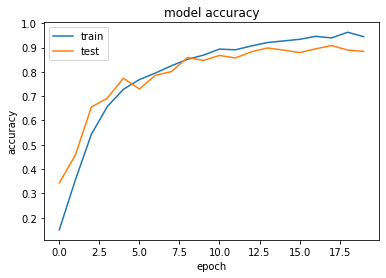

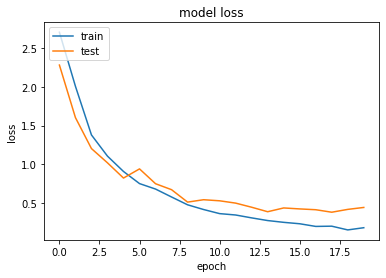

In [78]:
# plot everything
# summarize history for accuracy
plt.plot(history_CONV1D.history['accuracy'])
plt.plot(history_CONV1D.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_CONV1D.history['loss'])
plt.plot(history_CONV1D.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [79]:
_, train_accuracy = model_CONV1D.evaluate(x_train, y_train)
_, test_accuracy = model_CONV1D.evaluate(x_test, y_test)

27/27 [==============================] - 1s 49ms/step - loss: 0.6608 - accuracy: 0.8112


#### 5.2 model_LSTM_Ch_by_Ch

In [80]:
model_LSTM_Ch_by_Ch.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history_LSTM_Ch_by_Ch = model_LSTM_Ch_by_Ch.fit(x_train, y_train, validation_split=0.3, epochs=20, batch_size=32, callbacks=[earlyStop])

Epoch 1/20
43/43 [==============================] - 112s 746ms/step - loss: 2.6462 - accuracy: 0.0845 - val_loss: 2.5669 - val_accuracy: 0.1020
Epoch 2/20
43/43 [==============================] - 13s 306ms/step - loss: 2.4239 - accuracy: 0.1771 - val_loss: 2.3328 - val_accuracy: 0.2143
Epoch 3/20
43/43 [==============================] - 14s 320ms/step - loss: 2.1869 - accuracy: 0.2762 - val_loss: 2.1011 - val_accuracy: 0.3197
Epoch 4/20
43/43 [==============================] - 13s 305ms/step - loss: 1.9569 - accuracy: 0.3550 - val_loss: 1.7142 - val_accuracy: 0.4439
Epoch 5/20
43/43 [==============================] - 13s 308ms/step - loss: 1.5903 - accuracy: 0.4971 - val_loss: 1.5354 - val_accuracy: 0.4898
Epoch 6/20
43/43 [==============================] - 14s 328ms/step - loss: 1.3034 - accuracy: 0.5787 - val_loss: 1.2642 - val_accuracy: 0.6020
Epoch 7/20
43/43 [==============================] - 14s 326ms/step - loss: 1.0729 - accuracy: 0.6640 - val_loss: 1.0220 - val_accuracy: 0.676

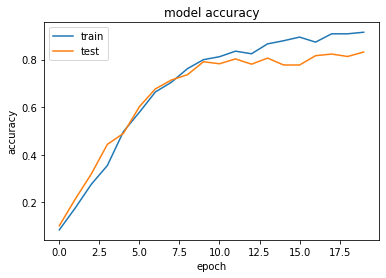

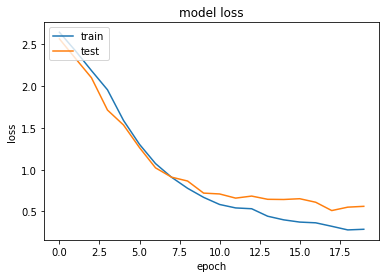

In [81]:
# plot everything
# summarize history for accuracy
plt.plot(history_LSTM_Ch_by_Ch.history['accuracy'])
plt.plot(history_LSTM_Ch_by_Ch.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_LSTM_Ch_by_Ch.history['loss'])
plt.plot(history_LSTM_Ch_by_Ch.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [82]:
_, train_accuracy = model_LSTM_Ch_by_Ch.evaluate(x_train, y_train)
_, test_accuracy = model_LSTM_Ch_by_Ch.evaluate(x_test, y_test)

27/27 [==============================] - 3s 120ms/step - loss: 0.7973 - accuracy: 0.7611


#### 5.3 model_LSTM_All_Ch

In [71]:
model_LSTM_All_Ch.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history_LSTM_All_Ch = model_LSTM_All_Ch.fit(x_train, y_train, validation_split=0.3, epochs=100, batch_size=32, callbacks=[earlyStop])

Epoch 1/100
43/43 [==============================] - 2s 24ms/step - loss: 2.5906 - accuracy: 0.1057 - val_loss: 2.5177 - val_accuracy: 0.1565
Epoch 2/100
43/43 [==============================] - 1s 12ms/step - loss: 2.5105 - accuracy: 0.1545 - val_loss: 2.5690 - val_accuracy: 0.1463
Epoch 3/100
43/43 [==============================] - 1s 12ms/step - loss: 2.4857 - accuracy: 0.1625 - val_loss: 2.3447 - val_accuracy: 0.2313
Epoch 4/100
43/43 [==============================] - 0s 12ms/step - loss: 2.1628 - accuracy: 0.2762 - val_loss: 2.1824 - val_accuracy: 0.2823
Epoch 5/100
43/43 [==============================] - 1s 12ms/step - loss: 1.9152 - accuracy: 0.3294 - val_loss: 1.7410 - val_accuracy: 0.3861
Epoch 6/100
43/43 [==============================] - 1s 12ms/step - loss: 1.9390 - accuracy: 0.3061 - val_loss: 1.7118 - val_accuracy: 0.3895
Epoch 7/100
43/43 [==============================] - 1s 13ms/step - loss: 1.8696 - accuracy: 0.3316 - val_loss: 1.7429 - val_accuracy: 0.3963
Epoch 

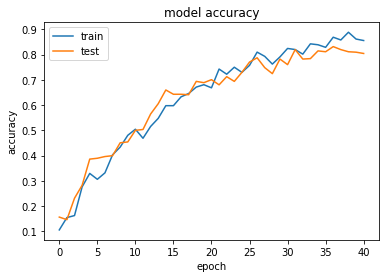

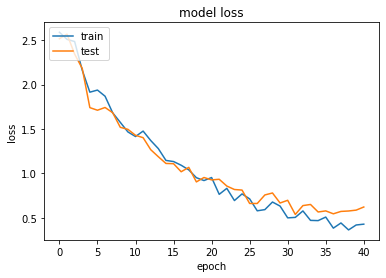

In [72]:
# plot everything
# summarize history for accuracy
plt.plot(history_LSTM_All_Ch.history['accuracy'])
plt.plot(history_LSTM_All_Ch.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_LSTM_All_Ch.history['loss'])
plt.plot(history_LSTM_All_Ch.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [73]:
_, train_accuracy = model_LSTM_All_Ch.evaluate(x_train, y_train)
_, test_accuracy = model_LSTM_All_Ch.evaluate(x_test, y_test)

27/27 [==============================] - 0s 6ms/step - loss: 0.8532 - accuracy: 0.7527


#### 5.4 Best model

The accuracy are the following :

    model_CONV1D : 0.81

    model_LSTM_Ch_by_Ch : 0.76

    model_LSTM_All_Ch : 0.75


The best model seems to be model_CONV1D with our current hyperparameters. However, during the next part, we will try to optimize the hyperparameter nbUnits to increase model_LSTM_All_Ch's accuracy since it is the fastest model we trained and it have capacity to give better results with tuninig.

### 6 Grid-search for nbUnits in model_LSTM_All_Ch

We try to find the best hyperparameter nbUnits for the model `model_LSTM_All_Ch` by doing a grid search.

#### 6.1 Code

In [32]:
lengthTimeseries = 100
nbClasses = 14
nbTimeseries = 66
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
earlyStop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)


def create_model_LSTM_All_Ch_Optimize_nbUnits(nbUnits=50):
    model = create_model_LSTM_All_Ch(nbClasses, nbUnits, lengthTimeseries, nbTimeseries)

    return model

In [33]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

## Cherchez le meilleur paramètre nbUnit pour create_model_LSTM_All_Ch
nbUnits=[50, 200, 300, 500, 850]
param_grid = dict(model__nbUnits=nbUnits)

model = KerasClassifier(model=create_model_LSTM_All_Ch_Optimize_nbUnits,
                        optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)

cv = GridSearchCV(estimator=model,
                  param_grid=param_grid,
                  cv=3)
cv.fit(x_train, y_train,
       validation_split=0.3,
       epochs=40,
       batch_size=32)

Epoch 1/40
29/29 [==============================] - 2s 28ms/step - loss: 2.6498 - accuracy: 0.0886 - val_loss: 2.6196 - val_accuracy: 0.0969
Epoch 2/40
29/29 [==============================] - 0s 11ms/step - loss: 2.5891 - accuracy: 0.1138 - val_loss: 2.5802 - val_accuracy: 0.1301
Epoch 3/40
29/29 [==============================] - 0s 9ms/step - loss: 2.5264 - accuracy: 0.1444 - val_loss: 2.5940 - val_accuracy: 0.1148
Epoch 4/40
29/29 [==============================] - 0s 9ms/step - loss: 2.4750 - accuracy: 0.1641 - val_loss: 2.4741 - val_accuracy: 0.1556
Epoch 5/40
29/29 [==============================] - 0s 9ms/step - loss: 2.4091 - accuracy: 0.1740 - val_loss: 2.3822 - val_accuracy: 0.1837
Epoch 6/40
29/29 [==============================] - 0s 9ms/step - loss: 2.2500 - accuracy: 0.2243 - val_loss: 2.1303 - val_accuracy: 0.2372
Epoch 7/40
29/29 [==============================] - 0s 9ms/step - loss: 2.1482 - accuracy: 0.2538 - val_loss: 2.1673 - val_accuracy: 0.2168
Epoch 8/40
29/29 [

GridSearchCV(cv=3,
             estimator=KerasClassifier(loss='categorical_crossentropy', metrics=['accuracy'], model=<function create_model_LSTM_All_Ch_Optimize_nbUnits at 0x7f6ece66e790>, optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f6ec1dd0b80>),
             param_grid={'model__nbUnits': [50, 200, 300, 500, 850]})

#### 6.2 Best nbUnits

Text(0, 0.5, 'accuracy')

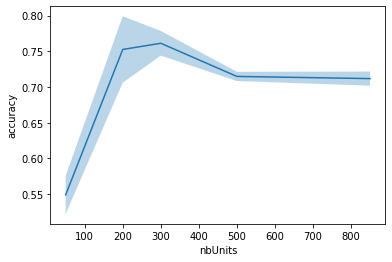

In [52]:
## Plot des résultats de la validation croisée ( on veut représenter l'évolution des performances en fonction
## des paramètres)
import seaborn as sns
import pandas as pd

res = cv.cv_results_
x = [x['model__nbUnits'] for x in res['params']]
y = res['mean_test_score']
stds = res['std_test_score']

sns.lineplot(x=x, y=y)
lower_bound = y - stds
upper_bound = y + stds
plt.fill_between(x, lower_bound, upper_bound, alpha=.3)
plt.xlabel('nbUnits')
plt.ylabel('accuracy')

The best hyperparameter is nbUnits=200.



In [65]:
nbUnits = 200

#### 6.3 Optimized accuracy

In [66]:
model_LSTM_All_Ch = create_model_LSTM_All_Ch(nbClasses=nbClasses, nbUnits=nbUnits, lengthTimeseries=lengthTimeseries, nbTimeseries=nbTimeseries)
model_LSTM_All_Ch.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history_LSTM_All_Ch = model_LSTM_All_Ch.fit(x_train, y_train, validation_split=0.3, epochs=100, batch_size=32, callbacks=[earlyStop])

Epoch 1/100
43/43 [==============================] - 2s 23ms/step - loss: 2.6110 - accuracy: 0.0977 - val_loss: 2.5182 - val_accuracy: 0.1395
Epoch 2/100
43/43 [==============================] - 1s 13ms/step - loss: 2.4755 - accuracy: 0.1283 - val_loss: 2.3907 - val_accuracy: 0.1990
Epoch 3/100
43/43 [==============================] - 0s 11ms/step - loss: 2.4125 - accuracy: 0.2041 - val_loss: 2.4415 - val_accuracy: 0.1650
Epoch 4/100
43/43 [==============================] - 0s 11ms/step - loss: 2.2284 - accuracy: 0.2558 - val_loss: 1.9709 - val_accuracy: 0.2976
Epoch 5/100
43/43 [==============================] - 0s 11ms/step - loss: 1.9735 - accuracy: 0.2996 - val_loss: 1.8466 - val_accuracy: 0.3537
Epoch 6/100
43/43 [==============================] - 0s 11ms/step - loss: 1.8010 - accuracy: 0.3550 - val_loss: 1.9429 - val_accuracy: 0.3622
Epoch 7/100
43/43 [==============================] - 0s 11ms/step - loss: 1.8445 - accuracy: 0.3535 - val_loss: 2.1339 - val_accuracy: 0.2840
Epoch 

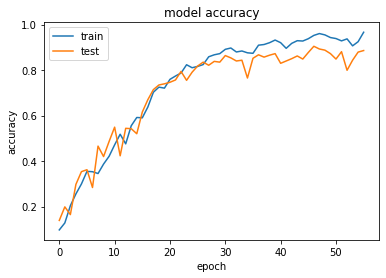

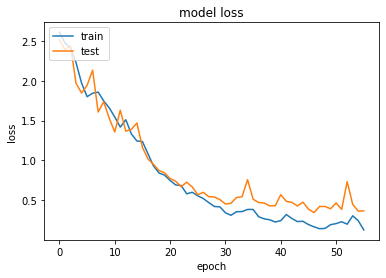

27/27 [==============================] - 0s 7ms/step - loss: 0.6098 - accuracy: 0.8339


In [67]:
# plot everything
# summarize history for accuracy
plt.plot(history_LSTM_All_Ch.history['accuracy'])
plt.plot(history_LSTM_All_Ch.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_LSTM_All_Ch.history['loss'])
plt.plot(history_LSTM_All_Ch.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
_, test_accuracy = model_LSTM_All_Ch.evaluate(x_test, y_test)

The accuracy are the following :

    model_CONV1D : 0.81

    model_LSTM_Ch_by_Ch : 0.76

    model_LSTM_All_Ch without tuning nbunits : 0.75

    model_LSTM_All_Ch with tuning nbunits : 0.84




### Summary
In this notebook, we presented a work that involve the temporal convolutional network, and RNN approaches for time series tasks. Overall, convolutional layers better identified the features in time series than LSTM. LSTM is less efficient in processing long history sequence. By tuning only nbunits we increase the accuracy of the model by 0.9, we can still tune other hyperparameters and get higher accuracy, such as the number of epocs and the batch size! A simple LSTM seems competitive with a complexe architecture with Conv1D! LSTMs are a theoretically stronger model and it can in theory learn to model arbitrarily long dependencies between its inputs (unlike the CNN with the limited window size).